# Air Quality Measurements in New Zealand - Exploratory Data Analysis

* Author: Fabian Löw
* Date: June 2023

In this notebook, we will explore some of the available air quality data in New Zealand. The dataset came from [Ministry for the Environment](https://data.mfe.govt.nz/) and can be downloaded [here](https://data.mfe.govt.nz/tables/category/environmental-reporting/air/?q=concentrations&updated_at.after=2021-02-05T02%3A21%3A54.805Z)


The exploratory data analysis (EDA) in this notebook is partly based on code form DeepLearning.AI and consists of the following steps: 

1. Import required Python packages and the utils.py (with additional functionality)
2. Load the air quality data (csv) that was previously downloaded and unzipped from MfE servers, do some restructuring of the data set and convert these from DBF into CSV file format
3. Count null values
4. Plot histograms of different pollutants
5. Make boxplots of pollutants at each measurement station
6. Investigate scatterplots of different pollutants and look for correlation
7. Generate simultaneous scatterplots and histograms across all pollutants
8. Construct a correlation matrix to quantitatively look for correlation
9. Look at measurements over time for different pollutants at different stations
10. Visualize the data in a map representation

## 1. Import required Python packages

Run the next cell to import the Python packages. Customized and run the next cell only if packages are not yet installed, skip otherwise.

In [251]:
# Install packages form pip, only use if requirements not already satisfied
!pip install seaborn folium colour dbfread simpledbf dbf

In [277]:
# Import packages
import os
import zipfile
import dbfread
import pandas as pd
import csv

from datetime import datetime

import utils

# If needed, reload the utils.py (e.g. if any adjustments are made)
import importlib 
utils = importlib.reload(utils)

print('All packages and functions from utils.py imported successfully')

All packages and functions from utils.py imported successfully


## 2. Load and convert the data

Run the next cell to load the air quality data. 

1. With the first line of code, define a pollutants_list object with the pollutants we will be working with. Make sure that only those pollutants are in pollutants_list that are in the data sets downloaded from MfE

2. Define a folderpath containing the unzipped datasets for MfE (DBF files with air quality measurements)

3. Find and show all DBF files found in the folder and store in object dbf_files

4. Identify the locatons names that all datasets have in common (because we want to create a dataframe holding measurements of different pollutants that were measured in ALL locations)

In [270]:
# Step-1: Define a list all of the pollutants that you will be working with
pollutants_list = ['PM2.5', 'PM10'] #,  'NO2', 'SO2', 'CO']

# Step 2: Read in the data, specify the folder path where the DBF files are located
folder_path = "/Users/fabianlow/Documents/14_Trainings/2023_Coursera_AIForGood/Week_2/air_quality/data/zip"

# Step 3: Find all DBF files in the folder
dbf_files = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith('.dbf'):
        dbf_files.append(os.path.join(folder_path, filename))

# Print the list of DBF files found
print("DBF files found:")
for dbf_file in dbf_files:
    print(dbf_file)

# Step 4: Read 'site' column from each DBF file
common_cities = None

for dbf_file in dbf_files:
    table = dbfread.DBF(dbf_file)
    cities = set(record['site'] for record in table)
    if common_cities is None:
        common_cities = cities
    else:
        common_cities = common_cities.intersection(cities)

# Step 5: Filter rows without common cities in each DBF file
for dbf_file in dbf_files:
    filtered_records = []
    table = dbfread.DBF(dbf_file)
    for record in table:
        if record['site'] in common_cities:
            filtered_records.append(record)

# Step 6: Save filtered DBF file as CSV
    base_name = os.path.splitext(dbf_file)[0]
    filtered_csv_file = f"{base_name}.csv"
    with open(filtered_csv_file, 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=table.field_names)
        writer.writeheader()
        writer.writerows(filtered_records)
    print(f"Filtered CSV file saved: {filtered_csv_file}")

# Print the number of CSV files saved
num_csv_files = len(dbf_files)
print(f"Total {num_csv_files} CSV files have been saved.")

DBF files found:
/Users/fabianlow/Documents/14_Trainings/2023_Coursera_AIForGood/Week_2/air_quality/data/zip/particulate-matter-10-concentrations-2004-2021.dbf
/Users/fabianlow/Documents/14_Trainings/2023_Coursera_AIForGood/Week_2/air_quality/data/zip/particulate-matter-25-concentrations-2006-2021.dbf
Filtered CSV file saved: /Users/fabianlow/Documents/14_Trainings/2023_Coursera_AIForGood/Week_2/air_quality/data/zip/particulate-matter-10-concentrations-2004-2021.csv
Filtered CSV file saved: /Users/fabianlow/Documents/14_Trainings/2023_Coursera_AIForGood/Week_2/air_quality/data/zip/particulate-matter-25-concentrations-2006-2021.csv
Total 2 CSV files have been saved.


### Some date formatting

1. Load the processed CSV files (thos containing only measurements from the common locations)

2. Modify the `DateTime` column for better formatting

In [262]:
# Step 1: Find all previous CSV files in the folder
csv_files = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith('.csv'):
        csv_files.append(os.path.join(folder_path, filename))
        
# Step 2: Apply the convert_to_datetime function to each previous CSV file and save the processed CSV files
df_list = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    processed_df = utils.convert_to_datetime(df)

    # Modify the CSV file name for saving the processed CSV file
    base_name = os.path.splitext(csv_file)[0]
    processed_csv_file = f"{base_name}_processed.csv"
    
    df_list.append(processed_df)

    # Save the processed CSV file
    processed_df.to_csv(processed_csv_file, index=False)
    print(f"Processed CSV file saved: {processed_csv_file}")

# Print the number of processed CSV files saved
num_processed_csv_files = len(csv_files)
print()
print(f"Total {num_processed_csv_files} processed CSV files have been processed.")

Processed CSV file saved: /Users/fabianlow/Documents/14_Trainings/2023_Coursera_AIForGood/Week_2/air_quality/data/zip/particulate-matter-25-concentrations-2006-2021_processed.csv
Processed CSV file saved: /Users/fabianlow/Documents/14_Trainings/2023_Coursera_AIForGood/Week_2/air_quality/data/zip/particulate-matter-10-concentrations-2004-2021_processed.csv

Total 2 processed CSV files have been processed.


### Filtering and merging of the data sets into one dataframe

1. Find the common date range among all dataframes

2. ... and filter data rows to keep only those measured at all locations

3. Concatenate the filtered (same locations, same measurement dates) dataframes.

4. Extract unique measurements locations and their coordinates and save to a seperate CSV file (will be used later in some of the plot functions)

In [288]:
# Step 1: Find the common date range among all dataframes
date_ranges = [df['DateTime'].min() for df in df_list], [df['DateTime'].max() for df in df_list]

common_start_date = min(date_ranges[0])
common_end_date = max(date_ranges[1])

print(f"The earliest common date recorded among all datasets is: {common_start_date}")
print(f"The latest common date recorded among all datasets is: {common_end_date}")
print()

# Step 2: Filter dataframes based on common date range
filtered_dfs = [df[(df['DateTime'] >= common_start_date) & (df['DateTime'] <= common_end_date)] for df in df_list]

# Sort each dataframe by DateTime column
for df in filtered_dfs:
    df.sort_values('DateTime', inplace=True)

# Step 3: Concatenate the filtered dataframes
merged_df = pd.concat(filtered_dfs, ignore_index=True)

# merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.sort_values("DateTime")
merged_df = merged_df.reset_index(drop=True)
measurement_columns = pollutants_list  # Replace with actual measurement column names

merged_df = merged_df[['long', 'lat', 'Station', 'DateTime'] + measurement_columns]
collapsed_df = merged_df.groupby(['DateTime', 'Station', 'lat', 'long'])[measurement_columns].first().reset_index()
collapsed_df.dropna(subset=measurement_columns, how='all', inplace=True)

# Step 4: Extract unique locations and their coordinates
locations_df = collapsed_df[['Station', 'lat', 'long']].drop_duplicates()

# Save the locations to a CSV file
locations_df.to_csv('data/stations_locations.csv', index=False)

# Print out the number of lines in the dataframe
print(f"The dataset contains {len(collapsed_df)} entries")

collapsed_df.to_csv("collapsed_df.csv", index=False)

# Print out the first few lines in the dataframe
collapsed_df.head(5)

The earliest common date recorded among all datasets is: 2004-12-31 00:00:00
The latest common date recorded among all datasets is: 2021-01-02 00:00:00

The dataset contains 105863 entries


,DateTime,Station,lat,long,PM2.5,PM10
6,2005-01-01,Ashburton,-43.912238,171.755200,NaN,9.0
7,2005-01-01,Geraldine,-44.100181,171.241500,NaN,2.0
8,2005-01-01,Kaiapoi,-43.384643,172.652000,NaN,9.0
9,2005-01-01,Masterton West,-40.952307,175.646614,NaN,10.0
10,2005-01-01,Penrose,-36.904610,174.815600,NaN,12.0


## 3. Count null values

Run the cell below to print out a count of the number of null values in each column of the merged dataset.

In [264]:
# Print out a count of null values for each column in the dataset
collapsed_df.isnull().sum()

DateTime        0
Station         0
lat             0
long            0
PM2.5       44470
PM10          775
dtype: int64

## 4. Plot histograms of selected pollutants from air measurements

Run the next cell to plot a histogram of a particular pollutant for particular sensor station in New Zealand. You can use the pulldown menus to select different pollutants and different sensor stations by their names.

In [279]:
# Define the number of bins to show in the histogram
number_of_bins=64

# Generate the histogram
utils.create_histogram_plot(collapsed_df, number_of_bins, pollutants_list)

interactive(children=(Dropdown(description='Station', options=('Ashburton', 'Blenheim Bowling Club', 'Kaiapoi'…

## 5. Create box plots of selected pollutants across all sensor stations

Run the next cell to generate box plots and use the pulldown menu to look at the distributions for different pollutants. 

In [280]:
# Generate boxplots of pollutant values for each sensor station
utils.create_boxplot(collapsed_df, pollutants_list)

interactive(children=(Dropdown(description='Pollutant', options=('PM2.5', 'PM10'), value='PM2.5'), Output()), …

## 6. Investigate scatter plots of different pollutants and look for correlation

Use the pulldown menus to better understand if there are any relationships between different pollutants. The colors on the plot indicate the concentration (density) of the measurement points. Areas of the plot that appear from blue to green, to red and orange show an increasing density of points. 

In [281]:
# Generate scatterplots of different pollutants against one another
utils.create_scatterplot(collapsed_df, pollutants_list)

interactive(children=(Dropdown(description='X-Axis', options=('PM2.5', 'PM10'), value='PM2.5'), Dropdown(descr…

## 7. Generate scatterplots and histograms across all pollutants

In the grid of plots, we will see each of the pollutants listed along both the vertical and horizontal axes. In each cell of the grid we'll find either a histogram (where the pollutant listed on the vertical and horizontal axis is the same) or a scatterplot showing the pollutant listed on the vertical axis plotted against the one shown on the horizontal axis.

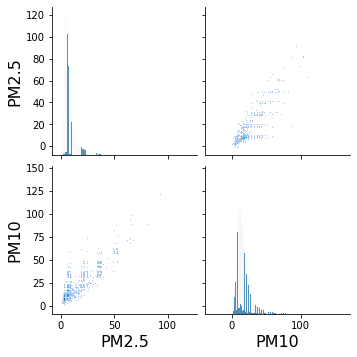

In [282]:
# generate a grid of histograms and scatterplots of your data
utils.plot_pairplot(collapsed_df, pollutants_list)

## 8. Generate a correlation matrix to quantitatively look for correlation
Create a correlation matrix to see how different variables correlate with each other, based on the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). Numbers closer to 1 or -1 indicate higher levels of correlation between two variables, while values close to 0 indicate no significant correlation between two variables.

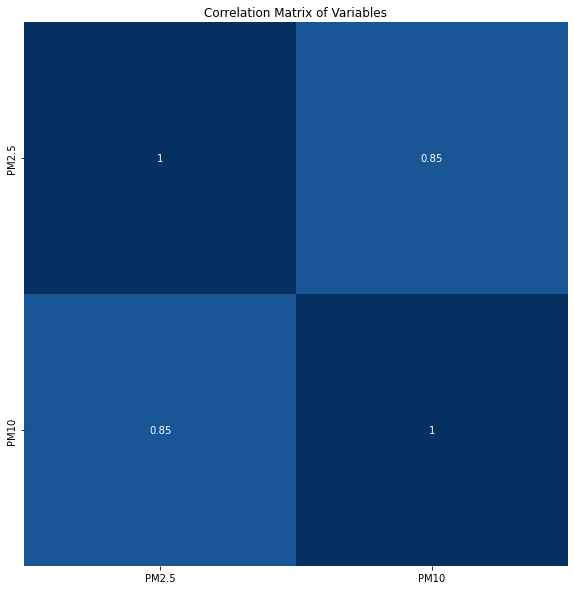

In [283]:
# generate a correlation matrix
utils.create_correlation_matrix(collapsed_df, pollutants_list)

## 9. Plot measurements over time for different pollutants at different stations

Run the cell below to generate a time series plot of a selected pollutant over time as measured at a particular sensor station. Use the pulldown menus to choose different stations and pollutants, respectively. Make use of the sliders to zoom in or out on a particular range of dates. The `start_date` and `end_date` values are calculated automatically.

In [285]:
# define the date range to show in the plot
start_date = common_start_date
end_date = common_end_date
# generate a time series plot of pollutant data for a paricular station
utils.create_time_series_plot(collapsed_df, start_date, end_date, pollutants_list)

interactive(children=(Dropdown(description='Station', options=('Ashburton', 'Blenheim Bowling Club', 'Kaiapoi'…

## 10. Visualize the air measurement data in a map 

Run the next cell to generate a map based on selected pollutanhts across New Zealand, based on the available air measuremnt data. A circle on the map shows each sensor station location. Each circle is colored based on the annual average of a selected pollutant measured at that location. Click on each sensor location to see a plot of the long-term average value and the recommended level of a pollutant. If you change where it says `hour_of_day` to `day_of_week` in the code, you'll see the daily average by day of the week in the plot when you click on each station. You can also change the pollutant to display in the map and the charts by changing the `y_variable` below.

In [287]:
# add some extra features like latitude and longitude to the data for mapping, 
enriched_raw_data = utils.add_extra_features(collapsed_df)

# choose a variable to calculate long-term averages for
x_variable = 'day_of_week' # Options ['day_of_week', 'hour_of_day'], depends on data
# choose a pollutant which you are interested in
y_variable = 'PM10' # Options could be 'PM2.5', 'PM10', 'NO', 'NO2', 'NOX', 'CO', 'OZONE', depending on data

# generate a map representation of the data
utils.create_map_with_plots(enriched_raw_data, x_variable, y_variable)

<Figure size 432x288 with 0 Axes>

*[End of notebook]*